# Compare CASTEP al3x3 benchmark performance

This notebook compares the performance of the small al3x3 benchmark across different UK HPC facilities.

Facilities included:

+ [Cirrus@EPCC](http://www.cirrus.ac.uk): HPE/SGI Ice XA. Two 2.1 GHz 18-core Xeon (Broadwell) per node. FDR hypercube
+ [Thomas@MMM](https://wiki.rc.ucl.ac.uk/wiki/Thomas): Lenovo. Two 12-core Xeon (Broadwell) per node, OPA 1:1 non-blocking (at the node counts investigated here)
+ [Athena@HPCM+](http://www.hpc-midlands-plus.ac.uk/): Huawei X6000. Two 2.4 GHz 14-core Xeon (Broadwell) per node, EDR 1:1 non-blocking (at the node counts investigated here)
+ [ARCHER](http://www.archer.ac.uk): Cray XC30. Two 2.7 GHz 18-core Xeon (IvyBridge) per node. Cray Aries dragonfly.

## Setup section

Import the required modules and define useful functions.

In [1]:
import re
from matplotlib import pyplot as plt
%matplotlib inline

Define a function to get the mean SCF cycle time from CASTEP output file. Minimum and maximum times found are removed before mean is computed to remove skewing due to long first step or very short step.

In [2]:
def getmeancycle(castepfilename):
    infile = open(castepfilename, 'r')
    tvals = []
    for line in infile:
        if re.search('<-- SCF', line):
            line = line.strip()
            tokens = line.split()
            if re.match('[0-9]+', tokens[0].lstrip()):
                tvals.append(float(tokens[4]))
    infile.close()

    deltat = []
    for i in range(len(tvals)-1):
        deltat.append(tvals[i+1] - tvals[i])
        
    deltat.remove(max(deltat))
    deltat.remove(min(deltat))
    
    return sum(deltat)/len(deltat)

Define a function to setup arrays of performance data for each system. Takes dictionary of CASTEP output files keyed by number of nodes and the number of cores per node. (Assumes all nodes are fully-populated.) Also print a summary of the data.

In [3]:
def calcperf(filedict, cpn):
    coreslist = []
    scflist = []
    sulist = []
    print "{:>15s} {:>15s} {:>15s} {:>15s}".format('Nodes', 'Cores', 'Mean SCF (s)', 'Speedup')
    print "{:>15s} {:>15s} {:>15s} {:>15s}".format('=====', '=====', '============', '=======')
    for nodes, filename in sorted(filedict.items()):
        coreslist.append(nodes*cpn)
        scf = getmeancycle(filename)
        scflist.append(scf)
        speedup = scflist[0]/scf
        sulist.append(speedup)
        print "{:>15d} {:>15d} {:>15.1f} {:>15.2f}".format(nodes, nodes*cpn, scf, speedup)
    return coreslist, scflist, sulist

## Read data and compute performance

### Cirrus

Cirrus results have versions compiled with both SGI MPT and Intel MPI

In [4]:
cirrusmptfiles = {1:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.1nodes',
                  2:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.2nodes',
                  4:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.4nodes',
                  8:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.8nodes',
                  16:'../al3x3/results/Cirrus/16.11_intel17_mpt214/al3x3.castep.16nodes'}

In [5]:
cirrusmptcpn = 36
cirrusmptcores, cirrusmptscf, cirrusmptsu = calcperf(cirrusmptfiles, cirrusmptcpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              36           102.4            1.00
              2              72            50.0            2.05
              4             144            31.4            3.27
              8             288            20.3            5.04
             16             576            20.7            4.95


In [16]:
cirrusimpifiles = {1:'../al3x3/results/Cirrus/17.21_gcc620_impi17/al3x3.castep.1nodes',
                  2:'../al3x3/results/Cirrus/17.21_gcc620_impi17/al3x3.castep.2nodes',
                  4:'../al3x3/results/Cirrus/17.21_gcc620_impi17/al3x3.castep.4nodes',
                  8:'../al3x3/results/Cirrus/17.21_gcc620_impi17/al3x3.castep.8nodes'}

In [17]:
cirrusimpicpn = 36
cirrusimpicores, cirrusimpiscf, cirrusimpisu = calcperf(cirrusimpifiles, cirrusimpicpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              36            90.1            1.00
              2              72            48.0            1.88
              4             144            31.5            2.86
              8             288            30.2            2.98


### Thomas

In [8]:
thomasfiles = {1:'../al3x3/results/Thomas/al3x3.castep.1nodes',
               2:'../al3x3/results/Thomas/al3x3.castep.2nodes'}

In [9]:
thomascpn = 36
thomascores, thomasscf, thomassu = calcperf(thomasfiles, thomascpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              36           123.3            1.00
              2              72            52.9            2.33


### Athena

In [10]:
athenafiles = {1:'../al3x3/results/Athena/al3x3.castep.1nodes',
               2:'../al3x3/results/Athena/al3x3.castep.2nodes',
               4:'../al3x3/results/Athena/al3x3.castep.4nodes',
               8:'../al3x3/results/Athena/al3x3.castep.8nodes',
               16:'../al3x3/results/Athena/al3x3.castep.16nodes'}

In [11]:
athenacpn = 28
athenacores, athenascf, athenasu = calcperf(athenafiles, athenacpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              28           100.6            1.00
              2              56            48.7            2.07
              4             112            40.1            2.51
              8             224            15.2            6.62
             16             448            18.8            5.35


### ARCHER

In [12]:
archerfiles = {1:'../al3x3/results/ARCHER/al3x3.castep.1nodes',
               2:'../al3x3/results/ARCHER/al3x3.castep.2nodes',
               4:'../al3x3/results/ARCHER/al3x3.castep.4nodes'}

In [13]:
archercpn = 24
archercores, archerscf, archersu = calcperf(archerfiles, archercpn)

          Nodes           Cores    Mean SCF (s)         Speedup
          =====           =====    ============         =======
              1              24           184.2            1.00
              2              48            88.2            2.09
              4              96            51.3            3.59


## Performance Comparison

### Mean SCF cycle time

This plot shows that performance for this benchmark is dominated by the on-node performance (processor/memory) as the more modern Xeon processors on the Tier-2 systems (Cirrus, Thomas, Athena) outperform the older Xeon processors on ARCHER.

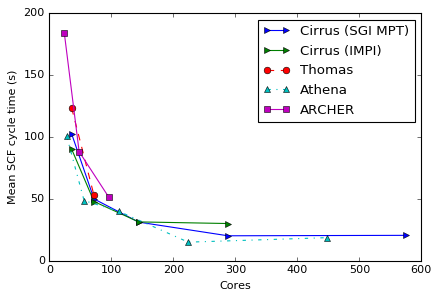

In [18]:
plt.plot(cirrusmptcores, cirrusmptscf, '>-', label='Cirrus (SGI MPT)')
plt.plot(cirrusimpicores, cirrusimpiscf, '>-', label='Cirrus (IMPI)')
plt.plot(thomascores, thomasscf, 'o--', label='Thomas')
plt.plot(athenacores, athenascf, '^-.', label='Athena')
plt.plot(archercores, archerscf, 's-', label='ARCHER')
plt.xlabel('Cores')
plt.ylabel('Mean SCF cycle time (s)')
plt.legend(loc='best')

### Speedup (relative to 1 node)

Here, we want to plot per-node rather than per-core as we are using fully-populated nodes and all speedups are relative to 1 node performance on the same system.

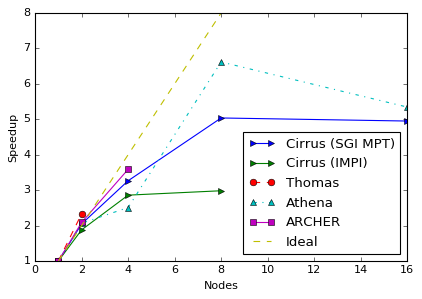

In [19]:
plt.plot([x/cirrusmptcpn for x in cirrusmptcores], cirrusmptsu, '>-', label='Cirrus (SGI MPT)')
plt.plot([x/cirrusimpicpn for x in cirrusimpicores], cirrusimpisu, '>-', label='Cirrus (IMPI)')
plt.plot([x/thomascpn for x in thomascores], thomassu, 'o--', label='Thomas')
plt.plot([x/athenacpn for x in athenacores], athenasu, '^-.', label='Athena')
plt.plot([x/archercpn for x in archercores], archersu, 's-', label='ARCHER')
x = range(1,9)
plt.plot(x, x, '--', label='Ideal')
plt.xlabel('Nodes')
plt.ylabel('Speedup')
plt.legend(loc='best')